# Normal modes frequency and Jij

In [1]:
from qutip import *
from scipy.optimize import fsolve, leastsq,root,brentq,newton,curve_fit
import math
import timeit
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from time import time 
from pynverse import inversefunc
from mpl_toolkits.axisartist.axislines import SubplotZero

The goal is to calculate the equilibrium positions, axial normal modes(and maybe CZ gate validity?) following the James1998 article, we'll also add the calculation of the radial mode and from there we can start the Qsim error analysis. 

Potential energy of the ion chain:

$V=\sum_{m=1}^{N} \frac{1}{2} M \omega^{2} x_{m}(t)^{2}+\sum_{n, m=1 \atop m \neq n}^{N} \frac{Z^{2} e^{2}}{8 \pi \epsilon_{0}} \frac{1}{\left|x_{n}(t)-x_{m}(t)\right|}$

Then equilibrium position is determined by:

$\left[\frac{\partial V}{\partial x_{m}}\right]_{x_{m}=x_{m}^{(0)}}=0$

Rewrite this in the length unit $l=(\frac{ e^{2}}{4 \pi \epsilon_{0} M \omega_z^{2}})^{1/3}$, we have: 

$u_{m}-\sum_{n=1}^{m-1} \frac{1}{\left(u_{m}-u_{n}\right)^{2}}+\sum_{n=m+1}^{N} \frac{1}{\left(u_{m}-u_{n}\right)^{2}}=0 \quad(m=1,2, \dots N)$


In [15]:
def Eqposition(N):
    p=np.empty(shape=(N))
    def func(u): # the equations
        for m in range(N):
            sum1=0
            sum2=0
            for n in range(m):
                sum1+=1/(u[m]-u[n])**2
            # sum1 = np.sum(1/(u[m]-u[:m])**2)
            for n in range(m+1,N):
                sum2+=1/(u[m]-u[n])**2
            p[m]=u[m]-sum1+sum2
        return p
    guess=np.empty(shape=(N))
    for i in range(N):
        guess[i]=3.94*(N**0.387)*np.sin(1/3*np.arcsin(1.75*N**(-0.982)*((i+1)-(N+1)/2))) # initial guess function
    x0=fsolve(func,guess,factor=0.01,xtol=1e-6, maxfev=100000)
    return(np.round(x0,5))
    print(func(x0))

Tried using symmetry of the solutions for optimazation but that didn't work. 

In [16]:
def Eqposition2(N):
    t0 = time()
    def func(u): #the equations
        p=np.empty(shape=(N))
        for m in range(N):
            sum1=0
            sum2=0
            for n in range(m):
                sum1+=1/(u[m]-u[n])**2
            for n in range(m+1,N):
                sum2+=1/(u[m]-u[n])**2
            p[m]=u[m]-sum1+sum2
        return p
    def dfunc(u): # first order derivative
        p=np.empty(shape=(N))
        for m in range(N):
            sum1=0
            sum2=0
            for n in range(m):
                sum1+=1/(u[m]-u[n])**3
            for n in range(m+1,N):
                sum2+=1/(u[m]-u[n])**3
            p[m]=1+2*sum1-2*sum2
        return p
    def ddfunc(u): # second order derivative
        p=np.empty(shape=(N))
        for m in range(N):
            sum1=0
            sum2=0
            for n in range(m):
                sum1+=1/(u[m]-u[n])**4
            for n in range(m+1,N):
                sum2+=1/(u[m]-u[n])**4
            p[m]=sum1-sum2
        return p
    guess=np.empty(shape=(N))
    for i in range(N):
        guess[i]=3.94*(N**0.387)*np.sin(1/3*np.arcsin(1.75*N**(-0.982)*((i+1)-(N+1)/2))) # initial guess function
    x0=newton(func,guess,fprime=dfunc,fprime2=ddfunc,maxiter=1000000) # newton method
    return(np.round(x0,5))
    print(time()-t0)
    print(func(x0))

In [17]:
def Eqposition3(N):
    t0 = time()
    
    def func(u): #the equations
        p=np.empty(shape=(N))
        for m in range(N):
            p[m]=u[m]-np.sum(1/(u[m]-u[:m])**2)+np.sum(1/(u[m]-u[m+1:])**2)
        return p
    
    def dfunc(u): # first order derivative
        p=np.empty(shape=(N))
        for m in range(N):
            p[m]=1+2*np.sum(1/(u[m]-u[:m])**3)-2*np.sum(1/(u[m]-u[m+1:])**3)
        return p
    
    def ddfunc(u): # second order derivative
        p=np.empty(shape=(N))
        for m in range(N):
            p[m]=np.sum(1/(u[m]-u[:m])**4) - np.sum(1/(u[m]-u[m+1:])**4)
        return p
    
    ni = np.arange(0,N)
    guess = 3.94*(N**0.387)*np.sin(1/3*np.arcsin(1.75*N**(-0.982)*((ni+1)-(N+1)/2)))
    
    x0=newton(func,guess,fprime=dfunc,maxiter=100000) # newton method
    
    return(np.round(x0,5))
    print('Time: ',time()-t0)
    print(func(x0))

In [18]:
def quarticEqposition(N,k,l):
    t0 = time()
    
    def func(u): #the equations
        p=np.empty(shape=(N))
        for m in range(N):
            p[m]=k*u[m]+l*(u[m]**3)-np.sum(1/(u[m]-u[:m])**2)+np.sum(1/(u[m]-u[m+1:])**2)
        return p
    
    def dfunc(u): # first order derivative
        p=np.empty(shape=(N))
        for m in range(N):
            p[m]=k+l*3*(u[m]**2)+2*np.sum(1/(u[m]-u[:m])**3)-2*np.sum(1/(u[m]-u[m+1:])**3)
        return p
    
    def ddfunc(u): # second order derivative
        p=np.empty(shape=(N))
        for m in range(N):
            p[m]=l*6*u[m]+np.sum(1/(u[m]-u[:m])**4) - np.sum(1/(u[m]-u[m+1:])**4)
        return p
    
    ni = np.arange(0,N)
    guess = 3.94*(N**0.387)*np.sin(1/3*np.arcsin(1.75*N**(-0.982)*((ni+1)-(N+1)/2)))
    
    x0=newton(func,guess,fprime=dfunc,fprime2=ddfunc,maxiter=100000) # newton method
    
    return(np.round(x0,5))
    print('Time: ',time()-t0)
    print(func(x0))

# tweezer potential

In [19]:
m = 88 *1.67*10**(-27)
e = 1
c = 3*10**8
epsilon_0 = 8.85*10**(-12)
I = 2*1*10**(-3)/(np.pi*(4*10**(-12)))# 1 mW 2 um beam intensity
Gamma = 1.279*10**8 #Sr+ P1/2 lifetime
w_0 = 2*np.pi*7.1096*10**14# Sr+ S-P transition
w = w_0 - 2*np.pi* 500*10**6
alpha = 6*np.pi*epsilon_0*(c**3)*Gamma/(w_0**2)/(w_0**2-w**2-1j*(w**3/w_0**2)*Gamma)

In [20]:
np.real(alpha)

1.0281203666093663e-33

In [21]:
U_dip = 3 *np.pi*c**2/(w_0**2)*Gamma/(w_0**2-w**2)*I*2*e/(10**(-12))*2/m # far_detuned  limit

In [22]:
U_dip_0 = -1/(2*epsilon_0*c)*np.real(alpha)*I*2*e/(10**(-12))*2/m

In [23]:
np.sqrt(U_dip)/(2*np.pi)/(10**6)

4.610258752923035

In [24]:
3 *np.pi*c**2/(w_0**2)*Gamma/(w_0**2-w**2)

1.9369988333843013e-31

In [25]:
ion_position_1 =Eqposition3(3)*l

NameError: name 'l' is not defined

In [26]:
l=((1.6e-19)**2*9e9/(40*1.66e-27*(2*np.pi*0.182e6)**2))**(1/3)*1e6 #wz = 0.246e6, axial freq
ion_position =Eqposition3(9)*l

In [27]:
ion_position

array([-37.10629155, -26.16155117, -16.88269398,  -8.30075824,
        -0.        ,   8.30075824,  16.88269398,  26.16155117,
        37.10629155])

In [28]:
np.average(ion_position[1:]-ion_position[:-1])

9.276572887994563

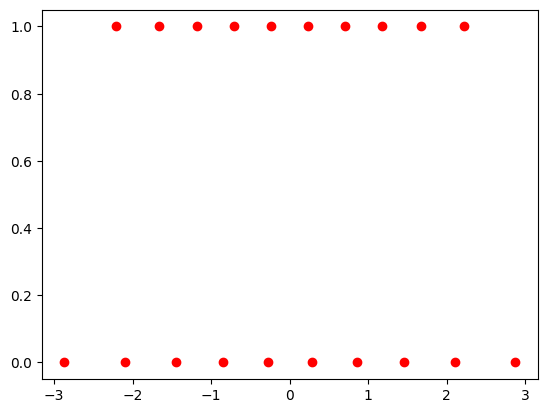

In [29]:
plt.plot(quarticEqposition(10,1,0),np.zeros(10),"ro")
plt.plot(quarticEqposition(10,1,0.3),np.ones(10),"ro")

In [30]:
N
np.arange(-int(N/2),int(N/2)+1)

NameError: name 'N' is not defined

Okay, after we apply the Newton method and the result converges, much better than fsolve. I've checked the err is less that $10^{-6}$ for N = 300. This is finally resolved. Also see James paper for reference(https://arxiv.org/pdf/physics/9711023.pdf), he used the fourth order Runge-Kutta method to get the equiposition of N = 1000.
We make use of the "analytic" result as the guess function:

$\begin{aligned} u_{n} &=\sqrt{\frac{4 A}{3 B}} \cos \left(\frac{1}{3} \cos ^{-1}\left[-\sqrt{\frac{27 B}{4 A^{3}}}\left\{n-\frac{(N+1)}{2}\right\}\right]+\frac{4 \pi}{3}\right) \\ &=\alpha(N) \sin \left(\frac{1}{3} \sin ^{-1}\left[\beta(N)\left\{n-\frac{(N+1)}{2}\right\}\right]\right) \end{aligned}$

With $\alpha(N)=\sqrt{4 A / 3 B} \approx 3.94 N^{0.387}$, $\beta(N)=\sqrt{27 B / 4 A^{3}} \approx 1.75 N^{-0.982}$

Now we calculate the mode spectrum. The Lagrangian of the system is:

$\begin{align} L &= \frac{M}{2} \sum_{m=1}^{N}\left(\dot{q}_{m}\right)^{2}-\frac{1}{2} \sum_{n, m=1}^{N} q_{n} q_{m}\left[\frac{\partial^{2} V}{\partial x_{n} \partial x_{m}}\right]_{0}\\
 &= \frac{M}{2}\left[\sum_{m=1}^{N}\left(\dot{q}_{m}\right)^{2}-\omega^{2} \sum_{n, m=1}^{N} A_{n m} q_{n} q_{m}\right]\end{align}$

For the axialmodes:

$A_{n m}=\left\{\begin{array}{cll}1+2 \sum_{p=1}^{N} \frac{1}{\left|u_{m}-u_{p}\right|^{3}} & \text { if } & n=m \\ p \neq m & & \\ \frac{-2}{\left|u_{m}-u_{n}\right|^{3}} & \text { if } & n \neq m\end{array}\right.$

The modes are eigenvalues of this determinant.

Radialmodes we have:

$A_{m, n}^{x, y}=\left(\left(\frac{\omega_{x, y}}{\omega_{z}}\right)^{2}+\frac{1}{2}\right) \delta_{m, n}-\frac{1}{2} A_{m, n}^{z}$

And the coupling between axial and radial terms would zero. 

In [64]:
def EqualAxialfull(N, wz): # N is the ion number, wz is the axial frequency, in MHz
    t0 =time()
    #u=np.arange(-int(N/2),int(N/2)+1)
    u=np.array([-2.0,-1.0,-0.2,0.2,1.0,2.0])
    u_1=np.empty(shape=(N))
    for i in range(N):
        u_1[i]= np.sum(1/np.absolute(u[i]-u[:i])**3) + np.sum(1/np.absolute(u[i]-u[i+1:])**3)
    A=np.empty((N,N))
    for i in range(N):
        for j in range(N):
            if j==i:
                A[i,j]=1+2*u_1[i] # A_mn, m==n
            else:
                A[i,j]=-2/np.absolute(u[i]-u[j])**3 #A_mn, m!=n
    print (time()-t0)
    w,v = np.linalg.eig(A)
    idx = np.argsort(w)
    w = w[idx]
    v = v[:,idx]
    return ([w,v])
    
def EqualAxialmodes(N, wz):
    t0 =time()
    return(np.sqrt(EqualAxialfull(N, wz)[0])*wz)

SyntaxError: invalid syntax (2487712176.py, line 22)

In [69]:
EqualAxialmodes(7, 0.170)

IndexError: index 6 is out of bounds for axis 0 with size 6

In [32]:
np.arange(-int(N/2),int(N/2)+1)

NameError: name 'N' is not defined

In [75]:
Axialmodes(9, 0.18)

0.00859522819519043


array([0.18      , 0.31176902, 0.43490255, 0.55175617, 0.66388723,
       0.77236691, 0.87795729, 0.98117233, 1.08236738])

0.00014829635620117188


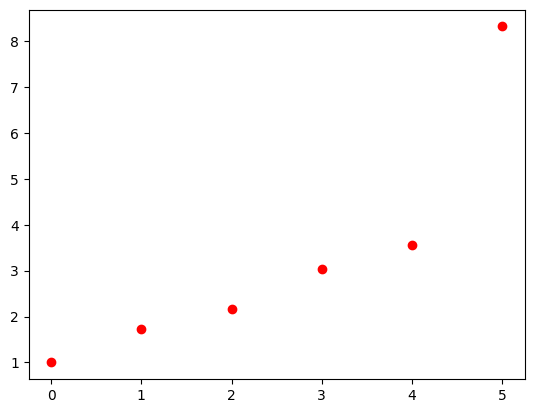

In [34]:
plt.plot(np.arange(6),EqualAxialmodes(6,1),"ro")

In [14]:
from qutip import *
from scipy.optimize import fsolve, leastsq,root,brentq,newton,curve_fit
import math
import timeit
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from time import time 
from pynverse import inversefunc
from mpl_toolkits.axisartist.axislines import SubplotZero

def Eqposition3(N):    
    def func(u): #the equations
        p=np.empty(shape=(N))
        for m in range(N):
            p[m]=u[m]-np.sum(1/(u[m]-u[:m])**2)+np.sum(1/(u[m]-u[m+1:])**2)
        return p
    def dfunc(u): # first order derivative
        p=np.empty(shape=(N))
        for m in range(N):
            p[m]=1+2*np.sum(1/(u[m]-u[:m])**3)-2*np.sum(1/(u[m]-u[m+1:])**3)
        return p
    ni = np.arange(0,N)
    guess = 3.94*(N**0.387)*np.sin(1/3*np.arcsin(1.75*N**(-0.982)*((ni+1)-(N+1)/2)))
    x0=newton(func,guess,fprime=dfunc,maxiter=100000) # newton method
    return(np.round(x0,5))

def Axialfull(N, wz): # N is the ion number, wz is the axial frequency, in MHz
    t0 =time()
    u=Eqposition3(N)
    u_1=np.empty(shape=(N))
    for i in range(N):
        u_1[i]= np.sum(1/np.absolute(u[i]-u[:i])**3) + np.sum(1/np.absolute(u[i]-u[i+1:])**3)
    A=np.empty((N,N))
    for i in range(N):
        for j in range(N):
            if j==i:
                A[i,j]=1+2*u_1[i] # A_mn, m==n
            else:
                A[i,j]=-2/np.absolute(u[i]-u[j])**3 #A_mn, m!=n
    print (time()-t0)
    w,v = np.linalg.eig(A)
    idx = np.argsort(w)
    w = w[idx]
    v = v[:,idx]
    return ([w,v])
    # return(np.sqrt(([w,v])[0])*wz) / 2

Axialfull(9, 0.18)

0.00889134407043457


[array([ 1.        ,  2.99999756,  5.83766132,  9.39613809, 13.60327953,
        18.41205695, 23.79040136, 29.71293644, 36.15799864]),
 array([[ 3.33333333e-01, -5.33892292e-01,  5.53213854e-01,
         -4.39433451e-01,  2.81183067e-01, -1.46525631e-01,
          6.13308853e-02, -1.96850844e-02,  4.23397213e-03],
        [ 3.33333333e-01, -3.76416971e-01,  9.69187832e-02,
          2.82770261e-01, -5.10764381e-01,  5.01491566e-01,
         -3.40726278e-01,  1.63882435e-01, -5.02094477e-02],
        [ 3.33333333e-01, -2.42908906e-01, -1.65789571e-01,
          4.01871711e-01, -1.87308582e-01, -2.58158709e-01,
          5.27377243e-01, -4.61355040e-01,  2.19525501e-01],
        [ 3.33333333e-01, -1.19434286e-01, -3.07808266e-01,
          2.55809206e-01,  2.22831120e-01, -4.00487864e-01,
         -2.27020388e-02,  5.09810330e-01, -4.93937111e-01],
        [ 3.33333333e-01, -9.15657425e-16, -3.53069600e-01,
         -2.58990322e-16,  3.88117552e-01, -2.28818939e-16,
         -4.50559622e

0.006339073181152344


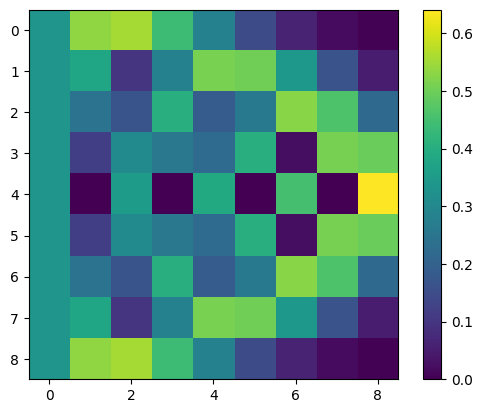

In [36]:
plt.imshow(np.abs(Axialfull(9,0.182)[1]))
plt.colorbar()

In [37]:
Axialfull(9,0.182)[1]

0.007073879241943359


array([[ 3.33333333e-01, -5.33892292e-01,  5.53213854e-01,
        -4.39433451e-01,  2.81183067e-01, -1.46525631e-01,
         6.13308853e-02, -1.96850844e-02,  4.23397213e-03],
       [ 3.33333333e-01, -3.76416971e-01,  9.69187832e-02,
         2.82770261e-01, -5.10764381e-01,  5.01491566e-01,
        -3.40726278e-01,  1.63882435e-01, -5.02094477e-02],
       [ 3.33333333e-01, -2.42908906e-01, -1.65789571e-01,
         4.01871711e-01, -1.87308582e-01, -2.58158709e-01,
         5.27377243e-01, -4.61355040e-01,  2.19525501e-01],
       [ 3.33333333e-01, -1.19434286e-01, -3.07808266e-01,
         2.55809206e-01,  2.22831120e-01, -4.00487864e-01,
        -2.27020388e-02,  5.09810330e-01, -4.93937111e-01],
       [ 3.33333333e-01, -9.15657425e-16, -3.53069600e-01,
        -2.58990322e-16,  3.88117552e-01, -2.28818939e-16,
        -4.50559622e-01,  1.64401267e-15,  6.40774172e-01],
       [ 3.33333333e-01,  1.19434286e-01, -3.07808266e-01,
        -2.55809206e-01,  2.22831120e-01,  4.004878

0.004280805587768555
0.004054069519042969
0.003470897674560547
0.0038759708404541016


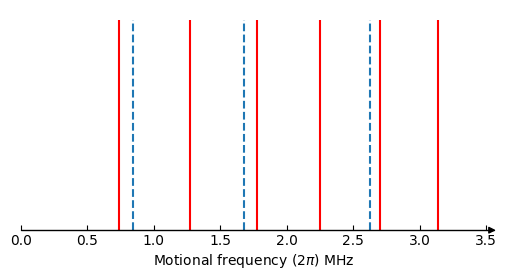

In [38]:
N = 6
w_z =0.735
fig = plt.figure(figsize=(6,3))
ax = SubplotZero(fig, 111)
fig.add_subplot(ax)

for direction in ["xzero"]:
    # adds arrows at the ends of each axis
    ax.axis[direction].set_axisline_style("-|>")

    # adds X and Y-axis from the origin
    ax.axis[direction].set_visible(True)

for direction in ["left", "right", "bottom", "top"]:
    # hides borders
    ax.axis[direction].set_visible(False)

plt.xticks(fontsize= 16)
plt.xlabel("Motional frequency $(2\pi)$ MHz",fontsize=16)
ax.vlines(Axialmodes(N, w_z),ymin=0,ymax=1,colors='r')
ax.vlines(np.array([Axialmodes(N,w_z)[0]+0.1076,Axialmodes(N,w_z)[2]-0.098,Axialmodes(N,w_z)[4]-0.0756]),ymin=0,ymax=1,linestyles='dashed')
plt.xlim([0, 3.5])
plt.savefig("6_ion_spectrum.pdf",dpi = 300, format = "pdf")

In [39]:
Axialfull(N,w_z)[1][0]

0.0039539337158203125


array([ 0.40824829, -0.60799974,  0.55312194,  0.35767765, -0.1654976 ,
        0.04902059])

0.005724906921386719
0.0050220489501953125
0.004539012908935547
0.0042989253997802734
0.004210948944091797
0.003977060317993164
0.00386810302734375
0.0032410621643066406
0.0037078857421875
0.0034971237182617188
0.0035741329193115234
0.0033538341522216797
0.0037360191345214844
0.0031681060791015625
0.0034072399139404297
0.0034036636352539062
0.0033626556396484375
0.0034220218658447266


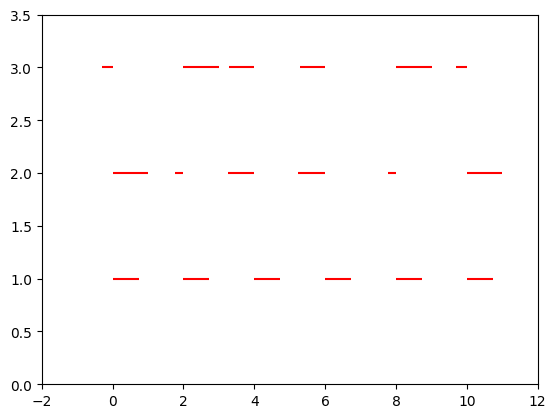

In [40]:
for i in range(6):
    plt.hlines(y=1,xmin =2*i,  xmax =2*i+1.8*Axialfull(N,w_z)[1][i,0], color= 'r')
    plt.hlines(y=2,xmin =2*i,  xmax =2*i+1.8*Axialfull(N,w_z)[1][i,2], color= 'r')
    plt.hlines(y=3,xmin =2*i,  xmax =2*i+1.8*Axialfull(N,w_z)[1][i,4], color= 'r')
plt.xlim(-2,12)
plt.ylim(0,3.5) 
# Showing the graph
plt.savefig("6_ion_mode.pdf",dpi = 300, format = "pdf")

0.003818988800048828


TypeError: object of type 'int' has no len()

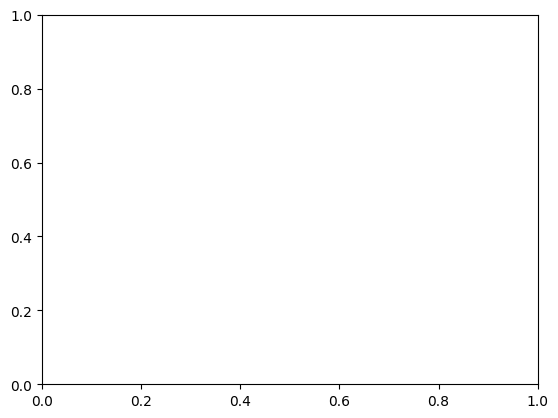

In [41]:
plt.hlines(1,0,  1.6*Axialfull(N,w_z)[1][0,0], 0,color= 'r')

0.00380706787109375


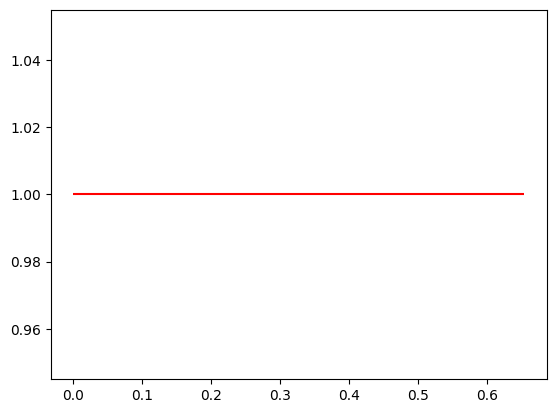

In [42]:
plt.hlines(y=1,xmin =0,  xmax =0+1.6*Axialfull(N,w_z)[1][0,0], color= 'r')

In [43]:
quarticAxialfull(5, 0.7)

NameError: name 'quarticAxialfull' is not defined

In [61]:
Axialfull(9, 0.17)

0.0055620670318603516


[array([ 1.        ,  2.99999756,  5.83766132,  9.39613809, 13.60327953,
        18.41205695, 23.79040136, 29.71293644, 36.15799864]),
 array([[ 3.33333333e-01, -5.33892292e-01,  5.53213854e-01,
         -4.39433451e-01,  2.81183067e-01, -1.46525631e-01,
          6.13308853e-02, -1.96850844e-02,  4.23397213e-03],
        [ 3.33333333e-01, -3.76416971e-01,  9.69187832e-02,
          2.82770261e-01, -5.10764381e-01,  5.01491566e-01,
         -3.40726278e-01,  1.63882435e-01, -5.02094477e-02],
        [ 3.33333333e-01, -2.42908906e-01, -1.65789571e-01,
          4.01871711e-01, -1.87308582e-01, -2.58158709e-01,
          5.27377243e-01, -4.61355040e-01,  2.19525501e-01],
        [ 3.33333333e-01, -1.19434286e-01, -3.07808266e-01,
          2.55809206e-01,  2.22831120e-01, -4.00487864e-01,
         -2.27020388e-02,  5.09810330e-01, -4.93937111e-01],
        [ 3.33333333e-01, -9.15657425e-16, -3.53069600e-01,
         -2.58990322e-16,  3.88117552e-01, -2.28818939e-16,
         -4.50559622e

In [45]:
def quarticAxialfull(N, wz): # N is the ion number, wz is the axial frequency, in MHz
    t0 =time()
    u=quarticEqposition(N,-1.5,1)
    u_1=np.empty(shape=(N))
    for i in range(N):
        u_1[i]= np.sum(1/np.absolute(u[i]-u[:i])**3) + np.sum(1/np.absolute(u[i]-u[i+1:])**3)
    A=np.empty((N,N))
    for i in range(N):
        for j in range(N):
            if j==i:
                A[i,j]=1+2*u_1[i] # A_mn, m==n
            else:
                A[i,j]=-2/np.absolute(u[i]-u[j])**3 #A_mn, m!=n
    print (time()-t0)
    w,v = np.linalg.eig(A)
    idx = np.argsort(w)
    w = w[idx]
    v = v[:,idx]
    return ([w,v])
    
def quarticAxialmodes(N, wz):
    t0 =time()
    return(np.sqrt(quarticAxialfull(N, wz)[0])*wz)

In [46]:
def Radialfull(N, wz, wx): #  N is the ion number, wz is the axial frequency, wx is the radial frequency, in MHz
    u=Eqposition3(N)
    u_1=np.empty(shape=(N))
    for i in range(N):
        u_1[i]= np.sum(1/np.absolute(u[i]-u[:i])**3) + np.sum(1/np.absolute(u[i]-u[i+1:])**3)
    
    A=np.empty((N,N))
    for i in range(N):
        for j in range(N):
            if j==i:
                A[i,j]=(wx/wz)**2-u_1[i] # A_mn, m==n
            else:
                A[i,j]=1/np.absolute(u[i]-u[j])**3 # A_mn, m!=n
    
    w,v = np.linalg.eig(A)
    idx = np.argsort(w)
    w = w[idx]
    v = v[:,idx]
    return ([w,v])

def Radialmodes(N, wz, wx):
    return np.sqrt(Radialfull(N, wz, wx)[0])*wz

In [47]:
Radialmodes(5, 0.25, 0.7)

array([0.31648057, 0.47918549, 0.58261989, 0.6538346 , 0.7       ])

In [48]:
#L-D parameter matrix 
def eta(N, wz, wx):
    t0 = time()
    A = Radialfull(N,wz,wx)
    eta = np.zeros((N,N))
    for i in range(N):
        eta[i] = 2*np.pi*np.sqrt(2)/(313.3e-9)*np.sqrt(1.0545718e-34/(2*9*1.66054e-27*2*np.pi*np.sqrt(A[0])*wz*1e6)) *  np.transpose(A[1])[:,i]
    #print(time()-t0)
    return eta

In [49]:
def etaYb(N, wz, wx):
    t0 = time()
    A = Radialfull(N,wz,wx)
    eta = np.zeros((N,N))
    for i in range(N):
        eta[i] = 2*np.pi*np.sqrt(2)/(355)*np.sqrt(1.0545718e-34/(2*171*1.66054e-27*2*np.pi*np.sqrt(A[0])*wz*1e6)) *  np.transpose(A[1])[:,i]
    #print(time()-t0)
    return eta

In [50]:
def EqualAxialfull(N, wz): # N is the ion number, wz is the axial frequency, in MHz
    t0 =time()
    #u=np.arange(-int(N/2),int(N/2)+1)
    u=np.array([-1.7429, -0.8121, -0.05    ,  0.8221,  1.7529])
    u_1=np.empty(shape=(N))
    for i in range(N):
        u_1[i]= np.sum(1/np.absolute(u[i]-u[:i])**3) + np.sum(1/np.absolute(u[i]-u[i+1:])**3)
    A=np.empty((N,N))
    for i in range(N):
        for j in range(N):
            if j==i:
                A[i,j]=1+2*u_1[i] # A_mn, m==n
            else:
                A[i,j]=-2/np.absolute(u[i]-u[j])**3 #A_mn, m!=n
    print (time()-t0)
    w,v = np.linalg.eig(A)
    idx = np.argsort(w)
    w = w[idx]
    v = v[:,idx]
    return ([w,v])
    
def EqualAxialmodes(N, wz):
    t0 =time()
    return(np.sqrt(EqualAxialfull(N, wz)[0])*wz)

In [51]:
EqualAxialmodes(5, 1)[1:]-EqualAxialmodes(5, 1)[:-1]

0.00022292137145996094
8.20159912109375e-05


array([0.72485938, 0.66654341, 0.62110005, 0.75710251])

In [52]:
l=((1.6e-19)**2*9e9/(40*1.66e-27*(2*np.pi*0.246e6)**2))**(1/3)*1e6 #wz = 0.15e6, axial freq 

In [53]:
Eqposition3(10)*l

array([-32.51139646, -23.78228871, -16.42517293,  -9.66883447,
        -3.19470848,   3.19470848,   9.66883447,  16.42517293,
        23.78228871,  32.51139646])

In [54]:
EqualAxialfull(5, 1)

0.00016379356384277344


[array([ 1.        ,  2.97513986,  5.7188073 ,  9.07517337, 14.2099245 ]),
 array([[ 0.4472136 , -0.61775725,  0.58606088, -0.24429657,  0.12340101],
        [ 0.4472136 , -0.28609867, -0.30573422,  0.49914953, -0.61280004],
        [ 0.4472136 , -0.06380261, -0.50044617,  0.14524512,  0.7241455 ],
        [ 0.4472136 ,  0.30456514, -0.26966815, -0.74320351, -0.28664911],
        [ 0.4472136 ,  0.66309338,  0.48978766,  0.34310543,  0.05190263]])]

In [55]:
Axialmodes(4, 1)[1:]-Axialmodes(4, 1)[:-1]

0.003660917282104492
0.0035021305084228516


array([0.73205274, 0.6783359 , 0.64057105])

0.0007190704345703125


ValueError: x and y must have same first dimension, but have shapes (3,) and (4,)

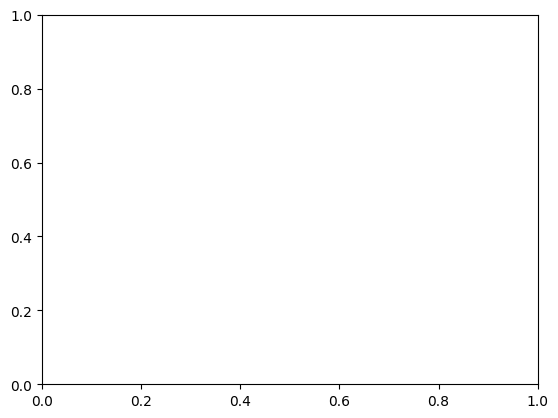

In [56]:
plt.plot(quarticAxialmodes(3, 0.7),np.ones(4),"ro")

In [57]:
Radialmodes(45,0.15,2.5)

/var/folders/d_/n_1tswj10tx48jnbz62dz3_00000gn/T/ipykernel_69794/3952988302.py:22: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(Radialfull(N, wz, wx)[0])*wz


array([       nan,        nan, 0.35096567, 0.60535921, 0.7781653 ,
       0.91667666, 1.0348341 , 1.13898924, 1.23257022, 1.31793294,
       1.39653587, 1.46944337, 1.53747608, 1.60123832, 1.66120739,
       1.71776153, 1.77124751, 1.82189464, 1.86995064, 1.91557453,
       1.95892858, 2.00016731, 2.03938878, 2.07670318, 2.11218933,
       2.1459336 , 2.17800589, 2.20845745, 2.23734071, 2.26469508,
       2.29055469, 2.31495368, 2.33791629, 2.35946313, 2.37960292,
       2.398342  , 2.41567939, 2.43160734, 2.44610879, 2.45915399,
       2.47069907, 2.48067663, 2.48898914, 2.49549594, 2.5       ])

Ising model with a transverse field:

$H=\sum_{i<j} J_{i, j} \sigma_{x}^{(i)} \sigma_{x}^{(j)}+B_{x} \sum_{i} \sigma_{x}^{(i)}+B_{y}(t) \sum_{i} \sigma_{y}^{(i)}$

$J_{i, j}$ is given by M-S interaction, $B_x$ and $B_y(t)$ are generated by a pair of Raman beams driving the carrier transition


Now calculate the Ising interaction.

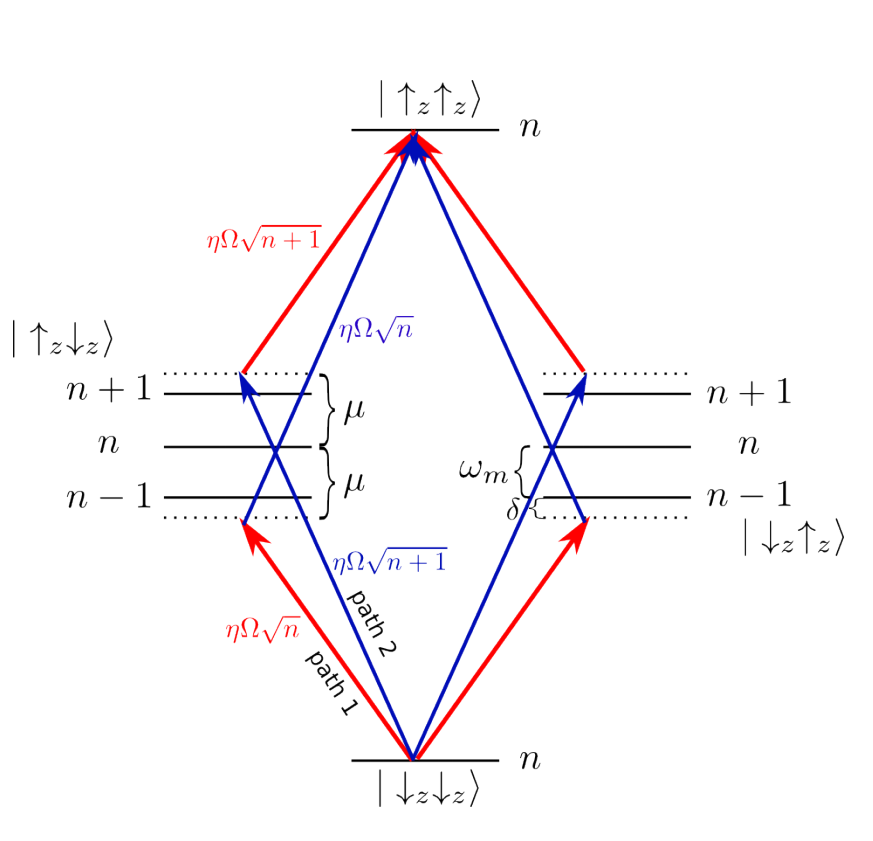

General M-S interaction for N ions:

$H_{M S}=-\sum_{i, m} \eta_{i, m} \Omega_{i} \sin (\mu t) \sigma_{i}^{x}\left(a_{m} e^{-i \omega_{m} t}+a_{m}^{\dagger} e^{i \omega_{m} t}\right)$

Use Magnus expansion we have the evolution operator:

$U(t)=T\left[e^{-i \int_{0}^{t} d t_{1} H\left(t_{1}\right)}\right]=e^{\bar{\Omega}_{1}+\bar{\Omega}_{2}+\bar{\Omega}_{3}+\cdots}$

Rewrite U with the M-S Hamiltonian:

$U(\tau)=\exp \left[\sum_{i} \hat{\phi}_{i} \sigma_{x}^{(i)}+i \sum_{i, j} \chi_{i, j}(\tau) \sigma_{x}^{(i)} \sigma_{x}^{(j)}\right]$

Higher order terms would be zero. 

$\hat{\phi}_{i}(\tau)=\sum_{m}\left[\alpha_{i, m}(\tau) a_{m}^{\dagger}-\alpha_{i, m}^{*}(\tau) a_{m}\right]$ represents spin-dependent displacements of the mth motional modes through phase
space by an amount:

$\alpha_{i, m}(\tau)=\frac{-i \eta_{i, m} \Omega_{i}}{\mu^{2}-\omega_{m}^{2}}\left[\mu-e^{i \omega_{m} \tau}\left(\mu \cos \mu \tau-i \omega_{m} \sin \mu \tau\right)\right]$

This would introduce unwanted spin flip which is the source of phonon err.

The second term:

$\chi_{i, j}(\tau)=\Omega_{i} \Omega_{j} \sum_{m} \frac{\eta_{i, m} \eta_{j, m}}{\mu^{2}-\omega_{m}^{2}}\left[\frac{\mu \sin \left(\mu-\omega_{m}\right) \tau}{\mu-\omega_{m}}-\frac{\mu \sin \left(\mu+\omega_{m}\right) \tau}{\mu+\omega_{m}}+\frac{\omega_{m} \sin 2 \mu \tau}{2 \mu}-\omega_{m} \tau\right]$


In the slow regime this can be simplified to:



$\begin{align}J_{i, j} &=\Omega_{i} \Omega_{j} \frac{\hbar(\Delta k)^{2}}{2 M} \sum_{m} \frac{b_{i, m} b_{j, m}}{\mu^{2}-\omega_{m}^{2}}\\
&= \sum_{n=1}^{N} \Omega_{i, n} \Omega_{j, n} \sum_{m=1}^{N} \frac{\eta_{i, m} \eta_{j, m} \omega_{m}}{\mu_{n}^{2}-\omega_{m}^{2}}
\end{align}$

This is just for the radialmodes, because the axialmodes are seperated, I don't think the approximation here $\omega \gg \delta \gg \eta\Omega $ would work. 

For simplification here we assume  Raman beam $\lambda$ = 313.3 nm, for Be+


In [ ]:
def Jij_x(i, j, N, wr, wb, wz, wx, mu): 
    t0 = time()
    # Radial Ising interaction between the i and j ion, total ion number N
    # wr,wb are RSB and BSB beam carrier frequency
    # wz,wz are axial and radial trap frequency
    # Detuning from carrier mu
    # All in MHz
    sum = 0
    A = Radialmodes(N, wz, wx)
    eta_1 = eta(N, wz, wx)
        #sum+= np.transpose(A[1])[m][i] * np.transpose(A[1])[m][j]/(mu**2-A[0][m]*(wz**2))
    sum = np.sum(eta_1[i]*eta_1[j]*A[:]/(mu**2-A[:]**2))
    if i != j:
        #return sum*wr*wb*1.0545718e-34 *(2*np.pi*np.sqrt(2)/(313.3e-9))**2/(2*9*1.66054e-27)/(2*np.pi*1000) 
        return sum *1000
    else: 
        return 0
# Yb lambda= 355 nm, mass= 171 amu

def FullJij(N, wr, wb, wz, wx ,mu): # Jij matrix
    t0 = time()
    A= np.zeros((N,N))
    sum = 0
    B = Radialmodes(N, wz, wx)
    eta_1 = eta(N, wz, wx)
    
    for i in range(N):
        for j in range(N):
            if i!=j:
                Jij = np.sum(eta_1[i]*eta_1[j]*B[:]/(mu**2-B[:]**2))* 1000
                A[i][j] = Jij
    #print(time()-t0)
    return A

# output in kHz #

# Calculating the full matrix can be easily improved using the symmerty #

In [ ]:
#fitting the interaction range alpha
def Jij_average(N, wr, wb, wz, wx ,mu): # Average of Jij for each |i-j|
    A = FullJij(N,wr, wb, wz, wx ,mu)
    B = []
    for i in range(1,N):
        sum = 0
        for j in range(N-i):
            sum += A[j][j+i]
        B.append(sum/(N-i))
    return B

def Jijfit(N, wr, wb, wz, wx ,mu): # fitting function
    def fitfunc(x,a,b):
        return a/(x**b)
    xdata = np.arange(1,N,1) # fitting data
    ydata = Jij_average(N, wr, wb, wz, wx ,mu)
    popt, pcov = curve_fit(fitfunc, xdata, ydata)
    plt.plot(xdata,ydata,'ro', label='data') #plot data and fit
    plt.plot(np.arange(1,N,0.3), fitfunc(np.arange(1,N,0.3), *popt), 'g--', label=r'fit: $\alpha$ = %5.3f' % tuple(popt)[1])
    plt.xlabel('|i-j|')
    plt.ylabel(r'|$J_{ij}$| (KHz)')
    plt.legend()
    plt.show()
    
    

The spin-dependent displacements of the mth motional modes through phase space by an amount:

$\alpha_{i, m}(\tau)=\frac{i \eta_{i, m} \Omega_{i}}{\mu^{2}-\omega_{m}^{2}}\left[\mu-e^{i \omega_{m} \tau}\left(\mu \cos \mu \tau-i \omega_{m} \sin \mu \tau\right)\right]$

Consider a single spin flip: 

We initialise at |$\uparrow_{z}$>, with ground state cooling. Under the time evolution:

$e^{\bar{\Omega}_{1}}$|$\uparrow_{z}$>|0> = $\downarrow_{z}$>|0> 



In [ ]:
# spin dependent displacement
def alpha_im(w, i,m, N, wz,wx, mu, t): # alpha amplitude on the ith ion, mth mode. i,m start from 0
    A = Radialfull(N,wz,wx)
    # L-D parameter
    eta_im = 2*np.pi*np.sqrt(2)/(313.3e-9)*np.sqrt(1.0545718e-34/(2*9*1.66054e-27*2*np.pi*np.sqrt(A[0][m])*wz*1e6)) * np.transpose(A[1])[m][i]
    a = 1j * w * eta_im  /(mu**2-A[0][m]*(wz**2)) * (mu-np.exp(np.sqrt(A[0][m])*wz*t*1j)*(mu*np.cos(mu*t)-1j*np.sqrt(A[0][m])*wz*np.sin(mu*t)))/(mu**2-A[0][m]*(wz**2))
    return a


def alpha_sum_m(w, i, N, wz, wx, mu,t):
    sum=0
    for m in range(N): 
        sum += np.absolute(alpha_im(w, i, m, N, wz, wx, mu, t))**2
    return sum


def alpha_sum_im(w, N, wz, wx, mu,t):
    sum=0
    for m in range(N): 
        for i in range(N): 
            sum += alpha_im(w, i, m, N, wz, wx, mu, t)
    return np.absolute(sum)**2

In [ ]:
N = 2
Jij = FullJij(N,1,1,0.15,6,6.3)
H_Ising = 0 
sx_list = []
sy_list = []
sz_list = []
for n in range(N):
    op_list = []
    for m in range(N):
        op_list.append(qeye(2))
        
    op_list[n] = sigmax()
    sx_list.append((tensor(op_list)))
    
    op_list[n] = sigmay()
    sy_list.append((tensor(op_list)))
    
    op_list[n] = sigmaz()
    sz_list.append((tensor(op_list)))
for i in range(N):
    for j in range(N):
        H_Ising += 1/2 * Jij[i][j] * sx_list[i] * sx_list[j] 
psi_list = []
for n in range(N):
    psi_list.append(basis(2,int((1+(-1)**n)/2))) #Neel order spin 
    #psi_list.append(basis(2,0))
psi0 = tensor(psi_list)
tlist = 2*np.pi*np.linspace(0, 5, 200)
result = mesolve(H_Ising, psi0, tlist)
    

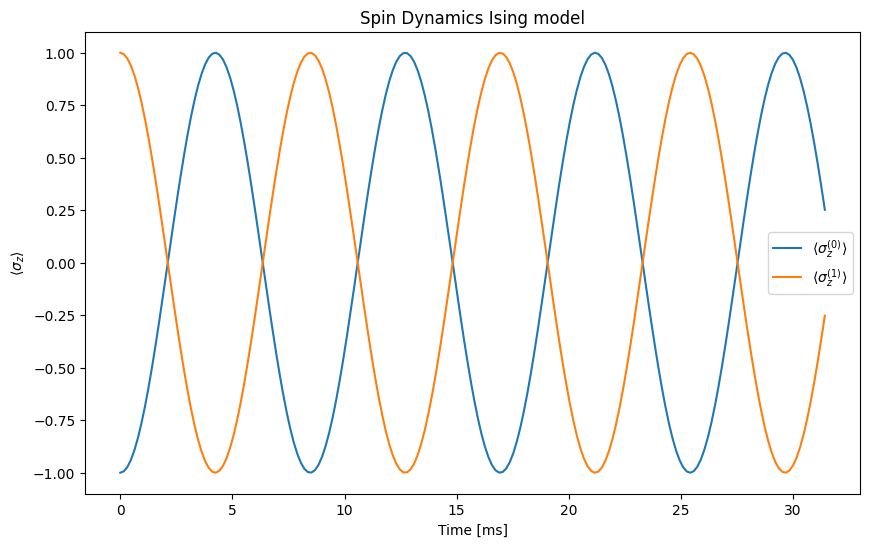

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))

for n in range(N):
    ax.plot(tlist, expect(sz_list[n], result.states), label=r'$\langle \sigma_z^{(%d)} \rangle$'%n)

ax.legend(loc=0)
ax.set_xlabel(r'Time [ms]')
ax.set_ylabel(r'$\langle \sigma_z \rangle$')
ax.set_title(r'Spin Dynamics Ising model');

In [ ]:
mu = 6.1
N=2
n_phonon = 3
sx_list = []
sy_list = []
sz_list = []
am = destroy(n_phonon)
am_list = []

# spin and phonon identity operators, seperate Hilbert space
op_list = []
for m in range(N):
    op_list.append(qeye(2))
spin_id = tensor(op_list)


op_list = []
for m in range(N):
    op_list.append(qeye(n_phonon))
phonon_id = tensor(op_list)

# spin x, y, and z operators, full Hilbert space, pure spins
for n in range(N):
    op_list = []
    for m in range(N):
        op_list.append(qeye(2))
        
    op_list[n] = sigmax()
    sx_list.append(tensor(tensor(op_list),phonon_id))
    
    op_list[n] = sigmay()
    sy_list.append(tensor(tensor(op_list),phonon_id))
    
    op_list[n] = sigmaz()
    sz_list.append(tensor(tensor(op_list),phonon_id))
    
# phonon operators, full hilbert space
for m in range(N):
    op_list = []
    for n in range(N):
        op_list.append(qeye(n_phonon))
        
    op_list[m] = am
    am_list.append(tensor(spin_id,tensor(op_list)))
    
#return sx_list[-1]*am_list[-1]
A= Radialmodes(N,0.15,6)
# now let's define some time-dependence
H = []
for m in range(N):
    def H1_coeff(t, args):
        return np.sin(mu*t)*np.exp(-(1j*t*A[m]))
    def H2_coeff(t, args):
        return np.sin(mu*t)*np.exp((1j*t*A[m]))
    
    for i in range(N):
        H1 = eta(N,0.15,6)[i][m]*sx_list[i]*am_list[m]
        H2 = eta(N,0.15,6)[i][m]*sx_list[i]*am_list[m].dag()
        H += [[H1,H1_coeff],[H2,H2_coeff]]

tlist = 2*np.pi*np.linspace(0, 15, 1000)
psi_list = []
for n in range(N):
    psi_list.append(basis(2,int((1+(-1)**n)/2))) #Neel order spin 
for n in range(N):
    psi_list.append(basis(n_phonon,0)) # phonon state
psi0 = tensor(psi_list)

result = mesolve(H, psi0, tlist)

test

In [ ]:
mu = 6.5
def fullSolve(N, n_phonon, delta_list, psi0, tlist):
    # NOTE: for now I've omitted the differences in the lamb-Dicke parameters, and set eta*Omega == 1 for all modes
    #eta_list, Bz, psi0, tlist, gamma, solver
#def checkOperators(N, n_phonon):   
#def checkHamiltonian (N, n_phonon, delta_list):
    # set up operators
    A = Radialmodes(N,0.15,6)
    sx_list = []
    sy_list = []
    sz_list = []
    am = destroy(n_phonon)
    am_list = []
    
    # spin and phonon identity operators, seperate Hilbert space
    op_list = []
    for m in range(N):
        op_list.append(qeye(2))
    spin_id = tensor(op_list)
    
    
    op_list = []
    for m in range(N):
        op_list.append(qeye(n_phonon))
    phonon_id = tensor(op_list)
    
    # spin x, y, and z operators, full Hilbert space, pure spins
    for n in range(N):
        op_list = []
        for m in range(N):
            op_list.append(qeye(2))
            
        op_list[n] = sigmax()
        sx_list.append(tensor(tensor(op_list),phonon_id))
        
        op_list[n] = sigmay()
        sy_list.append(tensor(tensor(op_list),phonon_id))
        
        op_list[n] = sigmaz()
        sz_list.append(tensor(tensor(op_list),phonon_id))
        
    # phonon operators, full hilbert space
    for m in range(N):
        op_list = []
        for n in range(N):
            op_list.append(qeye(n_phonon))
            
        op_list[m] = am
        am_list.append(tensor(spin_id,tensor(op_list)))
     
    #return sx_list[-1]*am_list[-1]
    
    # now let's define some time-dependence
    H = []
    for m in range(N):
        def H1_coeff(t, args):
            return 1j * np.exp(-(1j*t*(A[m]-mu)))
        def H2_coeff(t, args):
            return 1j * np.exp((1j*t*(A[m]-mu)))
        
        for i in range(N):
            H1 = eta(N,0.15,6)[i][m]*sx_list[i]*am_list[m]
            H2 = eta(N,0.15,6)[i][m]*sx_list[i]*am_list[m].dag()
            H += [[H1,H1_coeff],[H2,H2_coeff]]
            #H += [H2,H2_coeff]
    
    #return H
    
    result = mesolve(H, psi0, tlist)
    return result

In [ ]:
def fullSolve(N, n_phonon, delta_list, psi0, tlist):
    # NOTE: for now I've omitted the differences in the lamb-Dicke parameters, and set eta*Omega == 1 for all modes
    #eta_list, Bz, psi0, tlist, gamma, solver
#def checkOperators(N, n_phonon):   
#def checkHamiltonian (N, n_phonon, delta_list):
    # set up operators
    sx_list = []
    sy_list = []
    sz_list = []
    am = destroy(n_phonon)
    am_list = []
    
    # spin and phonon identity operators, seperate Hilbert space
    for n in range(N):
        op_list = []
        for m in range(N):
            op_list.append(qeye(2))
    spin_id = tensor(op_list)
    
    for n in range(N):
        op_list = []
        for m in range(N):
            op_list.append(qeye(n_phonon))
    phonon_id = tensor(op_list)
    
    # spin x, y, and z operators, full Hilbert space
    for n in range(N):
        op_list = []
        for m in range(N):
            op_list.append(qeye(2))
            
        op_list[n] = sigmax()
        sx_list.append(tensor(tensor(op_list),phonon_id))
        
        op_list[n] = sigmay()
        sy_list.append(tensor(tensor(op_list),phonon_id))
        
        op_list[n] = sigmax()
        sy_list.append(tensor(tensor(op_list),phonon_id))
        
    # phonon operators, full hilbert space
    for m in range(N):
        op_list = []
        for n in range(N):
            op_list.append(qeye(n_phonon))
            
        op_list[m] = am
        am_list.append(tensor(spin_id,tensor(op_list)))
     
    #return sx_list[-1]*am_list[-1]
    
    # now let's define some time-dependence
    H = []
    for m in range(N):
        def H1_coeff(t, args):
            return np.exp(-(1j*t*delta_list[m]))
        def H2_coeff(t, args):
            return np.exp((1j*t*delta_list[m]))
        
        for n in range(N):
            H1 =  sx_list[n]*am_list[m]
            H2 =  sx_list[n]*am_list[m].dag()
            H += [[H1,H1_coeff],[H2,H2_coeff]]
#            H += [H2,H2_coeff]
            
    #return H
    
    result = mesolve(H, psi0, tlist)
    return result

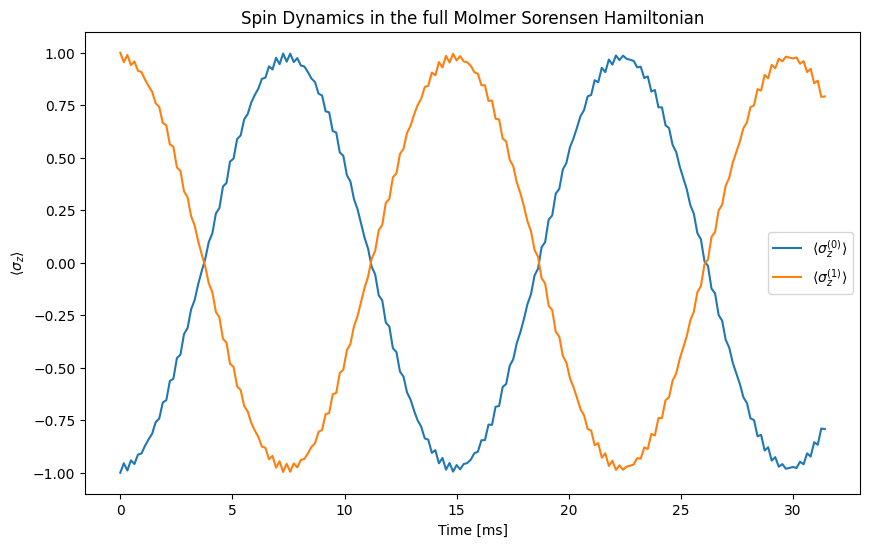

In [ ]:
N = 2
n_phonon = 3
# initial state, Neel order spin state, set all phonons to zero
psi_list = []
for n in range(N):
    psi_list.append(basis(2,int((1+(-1)**n)/2))) #Neel order spin 
for n in range(N):
    psi_list.append(basis(n_phonon,0)) # phonon state
psi0 = tensor(psi_list)

# detuning, this should come from the normal mode frequencies and laser frequency differences
delta_list = []
for n in range(N):
    delta_list.append(20.-n)

tlist = 2*np.pi*np.linspace(0, 5, 200)  
result = fullSolve(N,n_phonon, delta_list, psi0, tlist)

# set up spin operator in the full Hilbert space
sz_list = []
op_list = []
for n in range(N):
    op_list.append(qeye(n_phonon))
phonon_id = tensor(op_list)
for n in range(N):
    op_list = []
    for m in range(N):
        op_list.append(qeye(2))
    op_list[n] = sigmaz()
    sz_list.append(tensor(tensor(op_list),phonon_id)) #sz_list[n] the nth ion spin in the z basis  
    
# Plot spin excitations.
fig, ax = plt.subplots(figsize=(10,6))

for n in range(N):
    ax.plot(tlist, expect(sz_list[n], result.states), label=r'$\langle\sigma_z^{(%d)}\rangle$'%n)

ax.legend(loc=0)
ax.set_xlabel(r'Time [ms]')
ax.set_ylabel(r'$\langle\sigma_z\rangle $')
ax.set_title(r'Spin Dynamics in the full Molmer Sorensen Hamiltonian');

# Examples

In [ ]:
Eqposition3(300)

array([-15.44301, -15.05427, -14.74452, -14.47569, -14.23327, -14.00982,
       -13.8009 , -13.60359, -13.41583, -13.23613, -13.06335, -12.8966 ,
       -12.73516, -12.57845, -12.426  , -12.27739, -12.13227, -11.99036,
       -11.8514 , -11.71516, -11.58145, -11.45009, -11.32092, -11.19381,
       -11.06863, -10.94526, -10.82361, -10.70358, -10.58508, -10.46804,
       -10.35238, -10.23804, -10.12495, -10.01307,  -9.90232,  -9.79267,
        -9.68407,  -9.57647,  -9.46984,  -9.36413,  -9.25931,  -9.15535,
        -9.05222,  -8.94988,  -8.84831,  -8.74747,  -8.64736,  -8.54793,
        -8.44917,  -8.35105,  -8.25356,  -8.15667,  -8.06037,  -7.96464,
        -7.86945,  -7.7748 ,  -7.68067,  -7.58704,  -7.49389,  -7.40122,
        -7.30902,  -7.21725,  -7.12593,  -7.03502,  -6.94453,  -6.85443,
        -6.76473,  -6.6754 ,  -6.58645,  -6.49785,  -6.4096 ,  -6.32169,
        -6.23411,  -6.14686,  -6.05992,  -5.97329,  -5.88695,  -5.80091,
        -5.71515,  -5.62967,  -5.54446,  -5.45951, 

In [ ]:
l=((1.6e-19)**2*9e9/(40*1.66e-27*(2*np.pi*0.25e6)**2))**(1/3)*1e6

In [ ]:
(1.6e-19)**2*9e9/(40*1.66e-27*(200*10**(-6))**3*(2*np.pi*3*10**6))/(2*np.pi)

3.662211456951968

In [ ]:
l

11.203615965389476

In [ ]:
N = 20
distance = Eqposition(N)[1:]-Eqposition(N)[:-1]
np.std(distance)/np.average(distance)

/var/folders/d_/n_1tswj10tx48jnbz62dz3_00000gn/T/ipykernel_67039/3069941918.py:17: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  x0=fsolve(func,guess,factor=0.01,xtol=1e-6, maxfev=100000)


0.18580390680448422

In [ ]:
N = 20
distance_quartic = quarticEqposition(N,-1,1)[1:]-quarticEqposition(N,-1,1)[:-1]
np.std(distance_quartic)/np.average(distance_quartic)

0.0585536740104646

In [ ]:
distance_quartic

array([0.32437, 0.28498, 0.27068, 0.26626, 0.26711, 0.27101, 0.27636,
       0.28174, 0.28573, 0.2872 , 0.28573, 0.28174, 0.27636, 0.271  ,
       0.26712, 0.26626, 0.27068, 0.28498, 0.32437])

The following plot gives the equilibrium positions of the ions. Note that the length unit $l=(\frac{ e^{2}}{4 \pi \epsilon_{0} M \omega_z^{2}})^{1/3}$
 

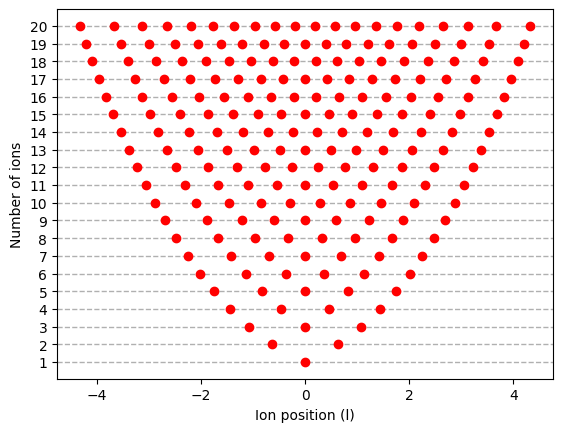

In [ ]:
l=((1.6e-19)**2*9e9/(9*1.66e-27*(2*np.pi*0.735e6)**2))**(1/3)*1e6 #wz = 0.15e6, axial freq 

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1) # plot grid 
grid_y_ticks = np.arange(0, 21, 1)
ax.set_yticks(grid_y_ticks)
ax.grid(axis='y')
for i in range(1,21):
    plt.plot(Eqposition3(i),i*np.ones(i), 'ro') # plot data
plt.ylabel('Number of ions')
plt.xlabel('Ion position (l)')
plt.grid(axis='y',linestyle='--', linewidth=1)
plt.savefig("equi_position.pdf", format="pdf", bbox_inches="tight")

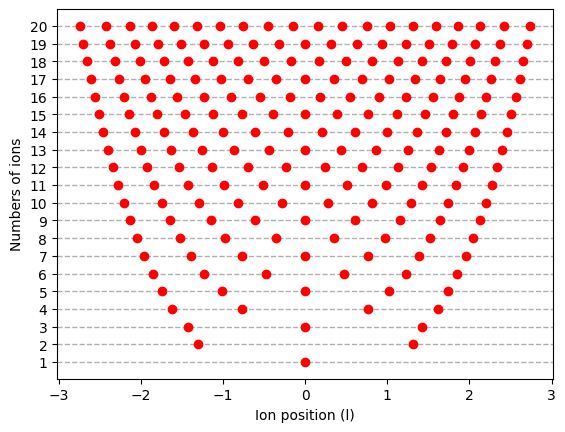

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1) # plot grid 
grid_y_ticks = np.arange(0, 21, 1)
ax.set_yticks(grid_y_ticks)
ax.grid(axis='y')
for i in range(1,21):
    plt.plot(quarticEqposition(i,-1.6,1),i*np.ones(i), 'ro') # plot data
plt.ylabel('Numbers of ions')
plt.xlabel('Ion position (l)')
plt.grid(axis='y',linestyle='--', linewidth=1)
plt.savefig("equi_quartic_position.pdf", format="pdf", bbox_inches="tight")

In [ ]:
l=((1.6e-19)**2*9e9/(138*1.66e-27*(2*np.pi*0.735e6)**2))**(1/3)*1e6

In [ ]:
l

3.6128807615284173

We use $\omega_z$= 150 kHz, $\omega_{x,y}$= 6 MHz here for calculating the modes. 

0.00010704994201660156
0.001180887222290039
0.0006549358367919922
0.0029630661010742188
0.0019598007202148438
0.004315853118896484
0.0036211013793945312
0.005135774612426758
0.00613093376159668
0.00722503662109375
0.008821964263916016
0.010707855224609375
0.01310586929321289
0.015758037567138672
0.01806497573852539
0.021278858184814453
0.024460792541503906
0.02797722816467285
0.03177690505981445
0.03721284866333008


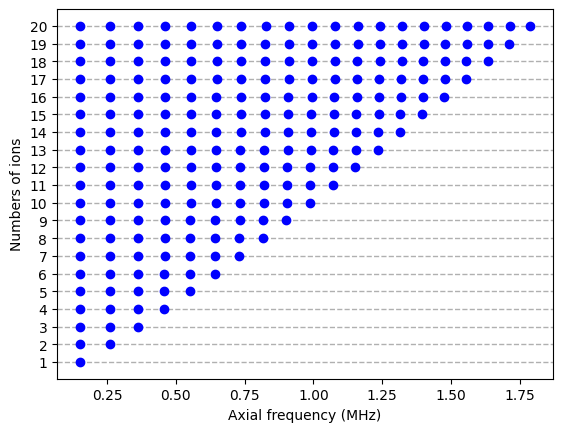

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
grid_y_ticks = np.arange(0, 21, 1) # plot grid
ax.set_yticks(grid_y_ticks)
ax.grid(axis='y')
for i in range(1,21):
    plt.plot(Axialmodes(i, 0.15),i*np.ones(i), 'o',color='b') # plot data
    plt.ylabel('Numbers of ions')
    plt.xlabel('Axial frequency (MHz)')
    plt.grid(axis='y',linestyle='--', linewidth=1)

In [ ]:
spacing = Axialmodes(10,1)[1:]-Axialmodes(10,1)[:-1]

0.011619091033935547
0.009948968887329102


In [ ]:
np.std(spacing)/np.average(spacing)

0.0909242620589721

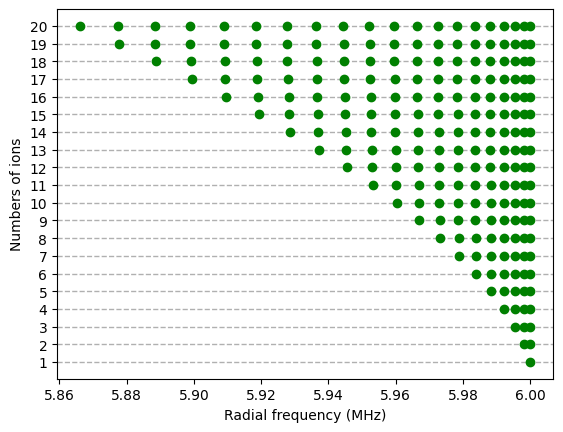

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
grid_y_ticks = np.arange(0, 21, 1) # plot grid
ax.set_yticks(grid_y_ticks)
ax.grid(axis='y')
for i in range(1,21):
    plt.plot(Radialmodes(i, 0.15, 6),i*np.ones(i), 'o',color='green') # plot data
    plt.ylabel('Numbers of ions')
    plt.xlabel('Radial frequency (MHz)')
    plt.grid(axis='y',linestyle='--', linewidth=1)

In [ ]:
Eqposition2(300) # N=300 eqpositions and err

array([-15.44301, -15.05427, -14.74452, -14.47569, -14.23327, -14.00982,
       -13.8009 , -13.60359, -13.41583, -13.23613, -13.06335, -12.8966 ,
       -12.73516, -12.57845, -12.426  , -12.27739, -12.13227, -11.99036,
       -11.8514 , -11.71516, -11.58145, -11.45009, -11.32092, -11.19381,
       -11.06863, -10.94526, -10.82361, -10.70358, -10.58508, -10.46804,
       -10.35238, -10.23804, -10.12495, -10.01307,  -9.90232,  -9.79267,
        -9.68407,  -9.57647,  -9.46984,  -9.36413,  -9.25931,  -9.15535,
        -9.05222,  -8.94988,  -8.84831,  -8.74747,  -8.64736,  -8.54793,
        -8.44917,  -8.35105,  -8.25356,  -8.15667,  -8.06037,  -7.96464,
        -7.86945,  -7.7748 ,  -7.68067,  -7.58704,  -7.49389,  -7.40122,
        -7.30902,  -7.21725,  -7.12593,  -7.03502,  -6.94453,  -6.85443,
        -6.76473,  -6.6754 ,  -6.58645,  -6.49785,  -6.4096 ,  -6.32169,
        -6.23411,  -6.14686,  -6.05992,  -5.97329,  -5.88695,  -5.80091,
        -5.71515,  -5.62967,  -5.54446,  -5.45951, 

In [ ]:
1.0545718e-34*(2*np.pi*np.sqrt(2)/(313.3e-9))**2/(2*9*1.66054e-27)/(2*np.pi*1000) #Yb+ recoil frequency#

451.6930219821873

The lower axial frequency makes a smaller Jij, because for each mode the sign is different, with lower axial freq the abs of these terms are closer, thus make a smaller Jij.

In [ ]:
Jij_x(1,2,10,0.6,0.6,0.95,4,4.122) #This is to compare with Islam's 2013 Science paper, result make sense#

/var/folders/d_/n_1tswj10tx48jnbz62dz3_00000gn/T/ipykernel_67039/3952988302.py:22: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(Radialfull(N, wz, wx)[0])*wz
/var/folders/d_/n_1tswj10tx48jnbz62dz3_00000gn/T/ipykernel_67039/738508705.py:7: RuntimeWarning: invalid value encountered in sqrt
  eta[i] = 2*np.pi*np.sqrt(2)/(313.3e-9)*np.sqrt(1.0545718e-34/(2*9*1.66054e-27*2*np.pi*np.sqrt(A[0])*wz*1e6)) *  np.transpose(A[1])[:,i]


nan

In [ ]:
1.0545718e-34 *(2*np.pi*np.sqrt(2)/(313.3e-9))**2/(2*9*1.66054e-27)/(2*np.pi*1000)*0.007543645825404677 


3.40741217964035

In [ ]:
np.transpose(Radialfull(2,0.15,6)[1])[1][0] * np.transpose(Radialfull(2,0.15,6)[1])[1][1]/(6.1**2-Radialfull(2,0.15,6)[0][1]*0.15**2)

0.41322314049586983

In [ ]:
(6.1**2-Radialfull(2,0.5,6)[0][1]*0.5**2)

1.2099999999999937

In [ ]:
# Spin-spin coupling profile
def Jijview(N):
    fig = plt.figure()
    ax1 = fig.add_subplot(111, projection='3d')

    x = np.array([[i] * N for i in range(N)]).ravel() + 1 # x coordinates of each bar
    y = np.array([i for i in range(N)] * N) + 1 # y coordinates of each bar
    z = np.zeros(N*N) # z coordinates of each bar
    dx = 0.6*np.ones(N*N) # length along x-axis of each bar
    dy = 0.6*np.ones(N*N) # length along y-axis of each bar
    dz = FullJij(N,1,1,1,6,6.1).ravel() # length along z-axis of each bar (height)
    ax1.view_init(50)
    plt.xlabel('Ion index i')
    plt.ylabel('Ion index j')
    plt.title('Jij (kHz)')
    ax1.bar3d(x, y, z, dx, dy, dz,color='blue',  edgecolor='gray')

# axial radial freq too different, interaction is short range

In [ ]:
FullJij(20,1,1,0.5,6,6.1)

array([[ 0.        , 59.36479257, 30.01726904, 18.26224391, 12.21431976,
         8.6580429 ,  6.38290542,  4.83975566,  3.74708076,  2.94731959,
         2.34631981,  1.88485161,  1.52405515,  1.23753731,  1.00682809,
         0.81861344,  0.66300747,  0.53233629,  0.42003445,  0.31851694],
       [59.36479257,  0.        , 56.50050109, 31.81029307, 20.38479365,
        14.03055071, 10.11147002,  7.52422541,  5.73128186,  4.44245566,
         3.48904906,  2.76725245,  2.21020299,  1.77320646,  1.4254289 ,
         1.14494404,  0.91569717,  0.72543583,  0.56395237,  0.42003445],
       [30.01726904, 56.50050109,  0.        , 53.09352283, 31.96640778,
        21.26735008, 14.97534625, 10.9466034 ,  8.21611545,  6.2874365 ,
         4.8813548 ,  3.8302327 ,  3.02817178,  2.40550695,  1.91483158,
         1.52285274,  1.20548815,  0.94461299,  0.72543583,  0.53233629],
       [18.26224391, 31.81029307, 53.09352283,  0.        , 50.31874075,
        31.68875873, 21.66098428, 15.5169446 , 1

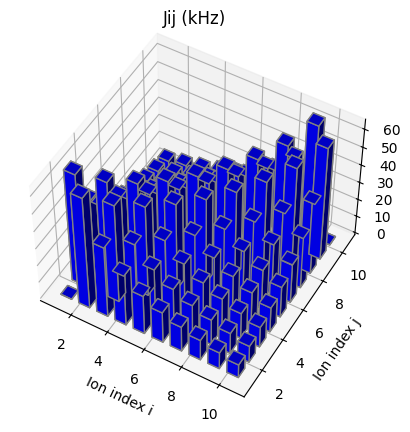

In [ ]:
Jijview(10)

I've check the symmetry of Jij and it makes sense.  Also compare to the Qsim example from Jiehang, doesn't look to fit very well. Need to check if $J_{i, j} \sim J /|i-j|^{\alpha}$. 

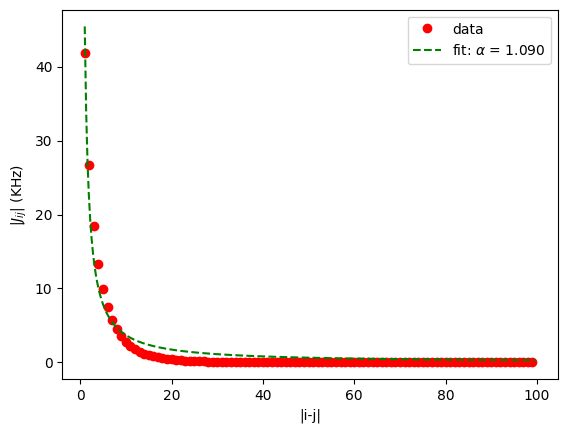

In [ ]:
Jijfit(100,1,1,0.15,6,6.1)

Plot flustrated Ising spin, compare to Kihwan's paper https://www.nature.com/articles/nature09071.pdf
I've checked the case with Yb+, 369.5 nm beam, $\omega_x$= 4.334 MHz, $\omega_z$ = 1.49 MHz, the number is roughly right but I don't know the Rabi frequency so cannot confirm

In [ ]:
mu = np.arange(-4, 1, 0.001)
plt.plot(mu,Jij_x(1,2,3,1,1,0.15,6, np.sqrt(mu*(0.15**2)+6**2)),'o', markersize=2, label = '$J_1$')
plt.plot(mu,Jij_x(1,3,3,1,1,0.15,6, np.sqrt(mu*(0.15**2)+6**2)),'ro',markersize=2, label = '$J_2$')
plt.ylim(-50000, 50000)
plt.legend()
plt.xlabel('$\mu^\prime = ( \mu^2 - \omega_x^2 )/\omega_z $')
plt.ylabel('J (2$\pi$ *KHz)')
plt.title('Flustrated Ising Spins Be+')
plt.show()

ValueError: operands could not be broadcast together with shapes (5000,) (3,) 

In [ ]:
# time plot in us
t=np.arange(0,20*np.pi,0.1)
plt.plot(t, phononerr(1,0, 5,0.15,6, 6.5,t))


NameError: name 'phononerr' is not defined

Text(0, 0.5, '$ |a(t)|^2$')

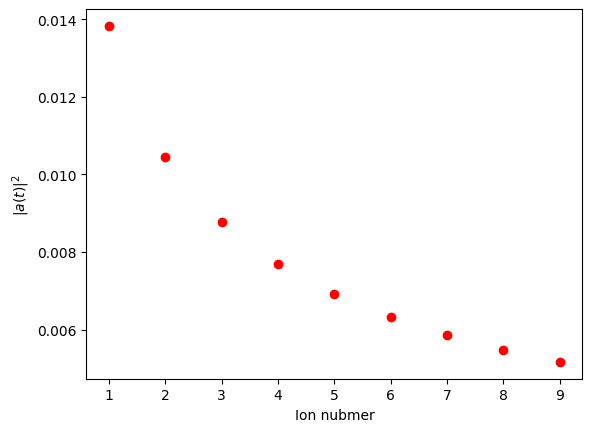

In [ ]:
# ion number plot sum over m


for N in range(1,10):
    plt.plot(N, alpha_sum_m(1, 0, N, 0.7,6, 6.1, 1),'ro')
plt.xlabel('Ion nubmer')
plt.ylabel('$ |a(t)|^2$')

In [ ]:
alpha_sum_m(1, 5, 100, 0.15,6, 6.1, 1)

0.0029996681789073174

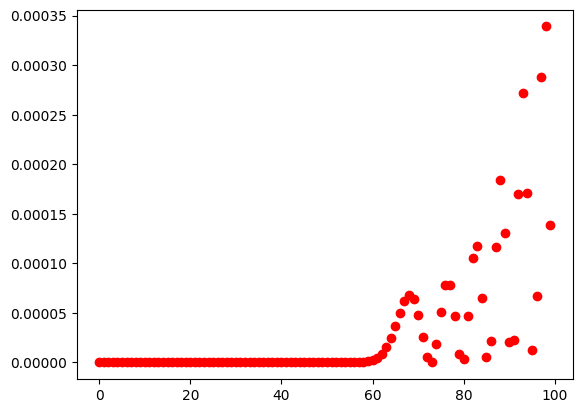

In [ ]:
for N in range(0,100):
     plt.plot(N,np.absolute(alpha_im(1, 5,N, 100, 0.15,6, 6.1, 1))**2,'ro')

In [ ]:
Radialmodes(100,0.15,6)

array([2.89277245, 2.97447977, 3.05335264, 3.12970448, 3.20363252,
       3.27539644, 3.34504439, 3.41273124, 3.47859454, 3.54266991,
       3.60513232, 3.66604675, 3.72541389, 3.78334727, 3.83998211,
       3.89525746, 3.9493786 , 4.00217672, 4.05386372, 4.10444331,
       4.15399784, 4.20245154, 4.24995943, 4.29647789, 4.3420396 ,
       4.38664513, 4.43040634, 4.47334787, 4.51545876, 4.55667982,
       4.59716869, 4.63685726, 4.67577767, 4.71395291, 4.75144021,
       4.78818286, 4.82426768, 4.85966677, 4.89439423, 4.92844161,
       4.96187854, 4.9946799 , 5.02684943, 5.05843695, 5.08940603,
       5.11979511, 5.14961774, 5.17883775, 5.20748535, 5.23559306,
       5.2631547 , 5.29016506, 5.3166458 , 5.34258805, 5.36800895,
       5.39291382, 5.41730149, 5.44117601, 5.46453748, 5.48740619,
       5.50977415, 5.53165164, 5.55304293, 5.57393872, 5.59435277,
       5.61429152, 5.63373834, 5.65271052, 5.671214  , 5.68923885,
       5.7067857 , 5.72386273, 5.74046973, 5.7566058 , 5.77227

In [ ]:
def RadialVar(x):
    return Radialmodes(20,x,6)[0]-1
sol = fsolve(RadialVar,0.7)

/var/folders/d_/n_1tswj10tx48jnbz62dz3_00000gn/T/ipykernel_67039/3952988302.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  A[i,j]=(wx/wz)**2-u_1[i] # A_mn, m==n


In [ ]:
sol

array([0.70390274])

In [ ]:
Radialmodes(20,0.70390274,6)

array([1.00000015, 1.98351554, 2.60025879, 3.07888969, 3.47673223,
       3.81887821, 4.11898526, 4.38546166, 4.62387913, 4.83811527,
       5.03098135, 5.20452826, 5.36027818, 5.49933896, 5.62246212,
       5.73008557, 5.82229896, 5.89876598, 5.95856696, 6.        ])

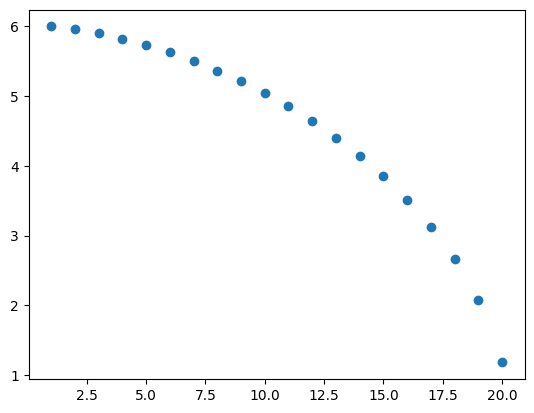

In [ ]:
plt.plot(np.arange(1,21),np.flip(Radialmodes(20,0.7,6)),'o')

In [ ]:
def Radialfit(N, wz, wx ): # fitting function
    def fitfunc(x,a,b):
        return a/(x**b)
    xdata = np.arange(1,N+1) # fitting data
    ydata = np.flip(Radialmodes(N, wz, wx))
    popt, pcov = curve_fit(fitfunc, xdata, ydata)
    plt.plot(xdata,ydata,'ro', label='data') #plot data and fit
    plt.plot(np.arange(1,N,0.3), fitfunc(np.arange(1,N,0.3), *popt), 'g--', label=r'fit: $\alpha$ = %5.3f' % tuple(popt)[1])
    plt.xlabel('|i-j|')
    plt.ylabel(r'|$J_{ij}$| (KHz)')
    plt.legend()
    plt.show()

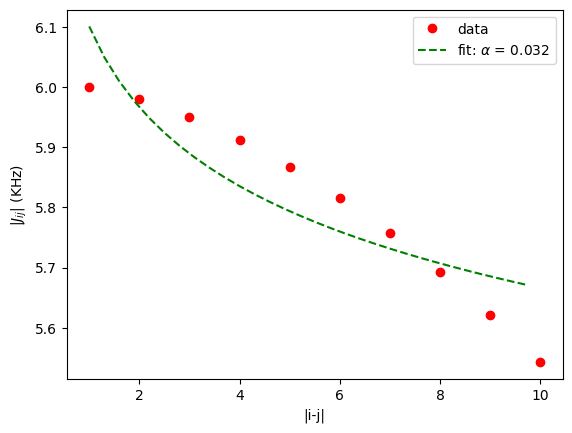

In [ ]:
Radialfit(10,0.5,6)